# Proyecto: Predicción de Abandono de Clientes Bancarios

## Introducción a los Datasets

### Dataset 1: Predicción de Abandono de Clientes Bancarios (Bank Customer Churn)

**Descripción General:**
Este conjunto de datos contiene información sobre clientes de un banco y su comportamiento, con el objetivo de predecir si un cliente abandonará o no el banco (*churn*). La variable objetivo es `Exited`, que indica si el cliente dejó de ser parte del banco (`1`) o si permaneció (`0`).

**Características del Dataset (Variables relevantes):**
- `CustomerId`: Identificador único del cliente.
- `Surname`: Apellido del cliente.
- `CreditScore`: Puntuación de crédito del cliente.
- `Geography`: País de residencia (ej. Francia, España, Alemania).
- `Gender`: Género del cliente.
- `Age`: Edad del cliente.
- `Tenure`: Años de permanencia en el banco.
- `Balance`: Saldo promedio del cliente.
- `NumOfProducts`: Número de productos que el cliente tiene con el banco.
- `HasCrCard`: Indica si tiene tarjeta de crédito.
- `IsActiveMember`: Indica si el cliente es considerado activo.
- `EstimatedSalary`: Salario estimado del cliente.
- `Exited`: (Variable objetivo) `1` si el cliente se fue del banco, `0` si sigue.

**Objetivo del Proyecto:**
Analizar los factores que influyen en la decisión de un cliente de abandonar el banco. A partir de esto, se puede crear un modelo predictivo que ayude al banco a identificar clientes en riesgo y tomar medidas preventivas de retención.



## 1. Información General
- **Nombre del Proyecto**: 
- **Nombres del Equipo y Roles**:
  - José Villarreal - Lider Tecnico
  - Yohana banda - Lider BI
  - Justin Ureña - Analista
  - José Lara - Analista
  - Gabriela Vivas- Analista
- **Resumen del Proyecto**:
Este proyecto busca identificar los factores que influyen en el abandono de clientes usando modelos de analítica de negocios y aprendizaje automático.

## 2. Perspectiva del Negocio
- Contexto del problema y por qué es relevante en el entorno empresarial.
- Impacto potencial de las predicciones.
- Aplicaciones reales en la toma de decisiones.

## 3. Análisis Exploratorio de Datos
- Cargar dataset.
- Revisar estructura de datos.
- Estadísticas descriptivas.
- Visualización inicial.

In [80]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score,
    precision_score, roc_auc_score, recall_score, ConfusionMatrixDisplay
)

from imblearn.pipeline import Pipeline as imbpipeline

In [81]:
#Cargar datos
df=pd.read_csv('Churn_Modelling.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 4. Preprocesamiento y Limpieza de Datos
- Identificación y manejo de valores nulos o duplicados.
- Transformaciones necesarias.
- Codificación y escalamiento si aplica.

In [82]:
# Preprocesamiento del dataset
# Verificar si hay valores nulos
null_values = df.isnull().sum()
# Verificar tipos de datos
data_types = df.dtypes

# Combinar resultados en un DataFrame para visualización como tabla
data_types = pd.DataFrame({
    'Column': df.columns,
    'Null Values': null_values.values,
    'Data Type': data_types.values
})

# Mostrar la tabla
data_types

,Column,Null Values,Data Type
0,RowNumber,0,int64
1,CustomerId,0,int64
2,Surname,0,object
3,CreditScore,0,int64
4,Geography,0,object
5,Gender,0,object
6,Age,0,int64
7,Tenure,0,int64
8,Balance,0,float64
9,NumOfProducts,0,int64


In [83]:
stats = df.describe().style.format(precision=2)

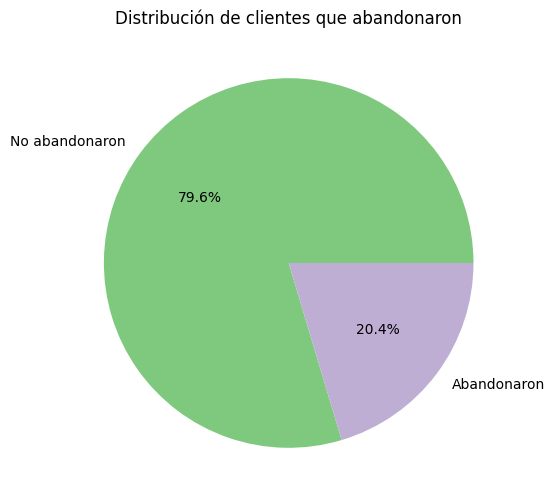

In [84]:
#Grafico de pastel para clientes que abandonan
# Contar los valores únicos de la columna "Exited"
conteo = df["Exited"].value_counts()

# Definir etiquetas personalizadas
labels = ["No abandonaron", "Abandonaron"]
palette = sns.color_palette("Accent", n_colors=2)
# Crear el gráfico
plt.figure(figsize=(6, 6))
plt.pie(
    conteo,
    labels=labels,  # Etiquetas manuales
    autopct="%1.1f%%",
    colors=palette
   
)
plt.title("Distribución de clientes que abandonaron")
plt.show()

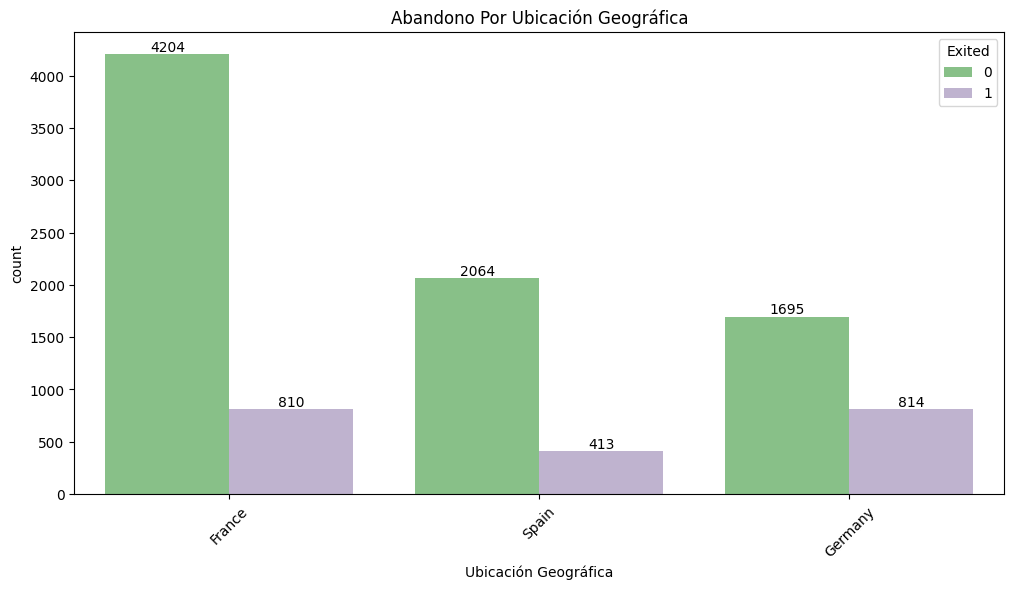

In [85]:
#Gráfico de Abandonos por ubicación geográfica
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Geography', hue='Exited', data=df, palette='Accent')
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.title('Abandono Por Ubicación Geográfica')
plt.xlabel('Ubicación Geográfica')
plt.xticks(rotation=45)
plt.show()

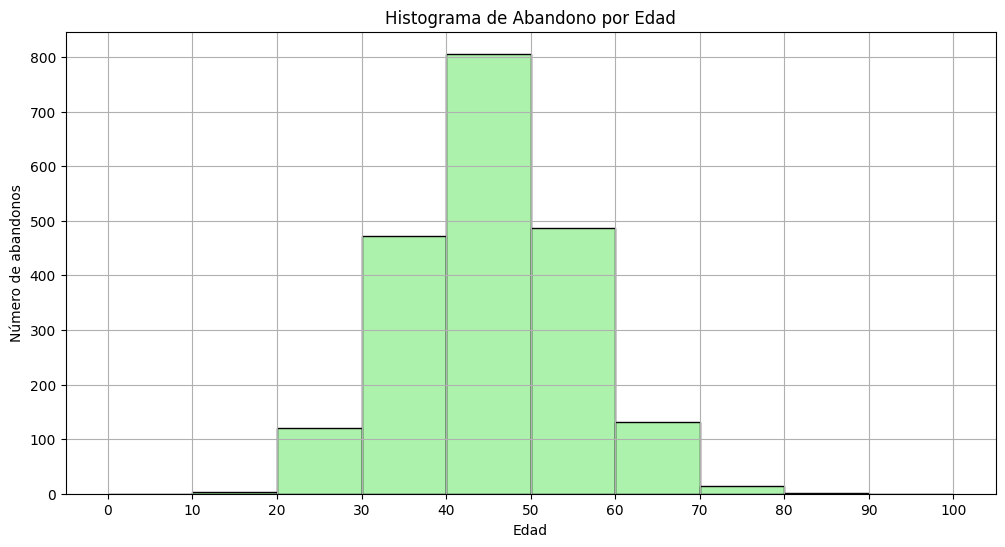

In [86]:
#Histograma por Edad 
#Gráfico de Abandonos por grupos de edad
# Crear grupos de edad
df['AgeGroup'] = pd.cut(df['Age'], bins=range(0, 101, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, 100, 10)])

# Filtrar solo los que abandonaron
exited_df = df[df['Exited'] == 1]

# Crear el histograma
plt.figure(figsize=(12, 6))
sns.histplot(data=exited_df, x='Age', bins=range(0, 101, 10), color='lightgreen', kde=False)

plt.title('Histograma de Abandono por Edad')
plt.xlabel('Edad')
plt.ylabel('Número de abandonos')
plt.xticks(range(0, 101, 10))
plt.grid(True)
plt.show()

C:\Users\Darki\AppData\Local\Temp\ipykernel_24836\416572936.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y="Balance", data=df, palette="Accent")


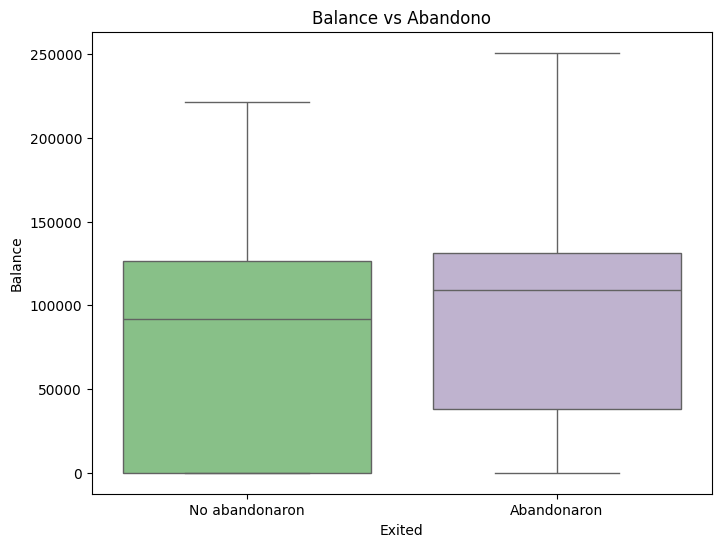

In [87]:
#Boxplot balance
plt.figure(figsize=(8, 6))
sns.boxplot(x="Exited", y="Balance", data=df, palette="Accent")
plt.title("Balance vs Abandono")
plt.xticks([0, 1], ["No abandonaron", "Abandonaron"])
plt.show()


In [88]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname","AgeGroup"])

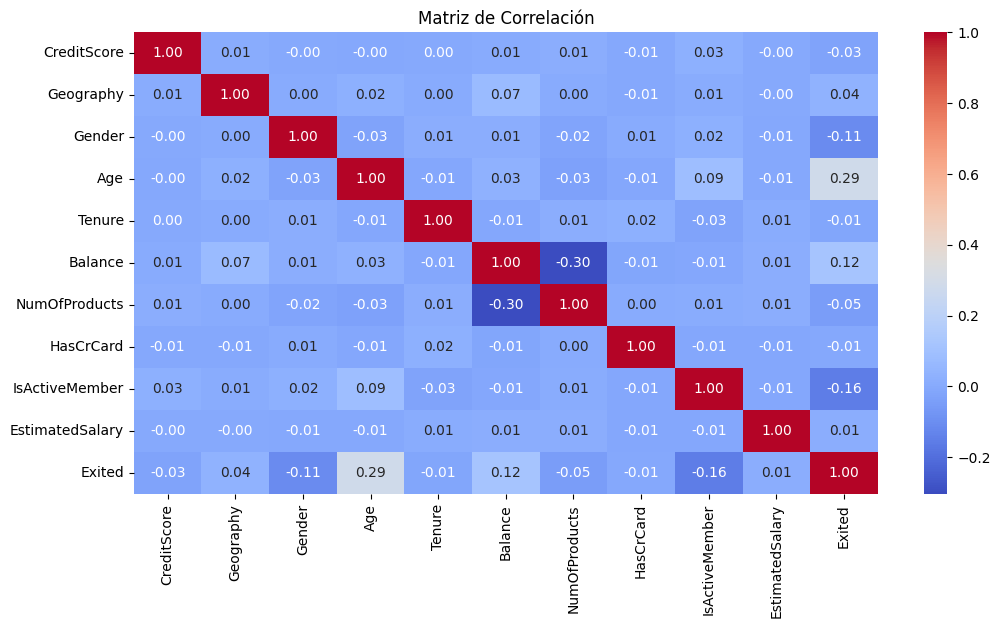

In [89]:
label_encoder=LabelEncoder()
df_encode=df.copy()
df_encode["Geography"]=label_encoder.fit_transform(df_encode["Geography"])
df_encode["Gender"]=label_encoder.fit_transform(df_encode["Gender"])
plt.figure(figsize=(12,6))
sns.heatmap(df_encode.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

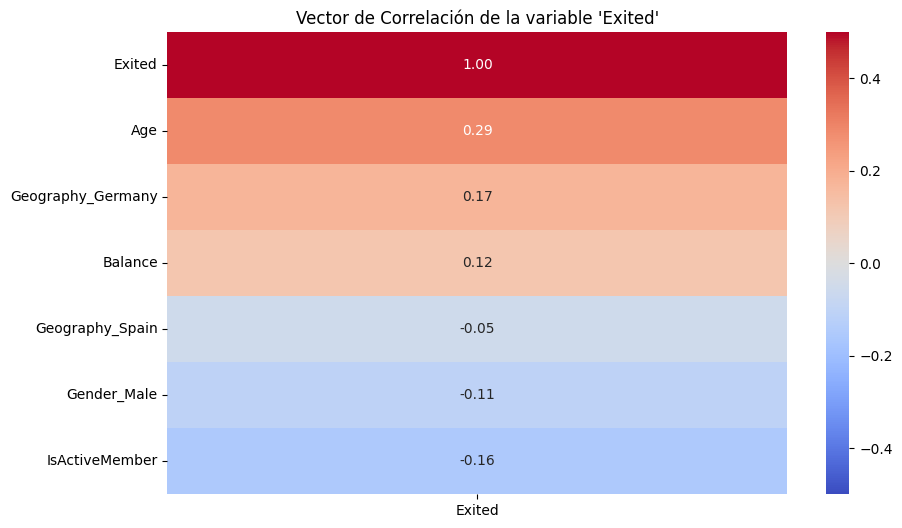

In [90]:
df_encoded = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)
plt.figure(figsize=(10, 6))
corr_matrix = df_encoded.corr(numeric_only=True)
target_corr = corr_matrix[["Exited"]].sort_values(by="Exited", ascending=False)

# Filtrar correlaciones con |r| >= 0.05 (umbral bajo para ver relaciones débiles)
target_corr = target_corr[(target_corr["Exited"] >= 0.05) | (target_corr["Exited"] <= -0.05)]

sns.heatmap(target_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-0.5, vmax=0.5)
plt.title("Vector de Correlación de la variable 'Exited'")
plt.show()

## 5. Modelado Predictivo
- División de datos de entrenamiento y prueba.
- Selección de modelos.
- Entrenamiento y validación.

In [91]:
# Entrenamiento de modelos
# Random Forest - Yohana
#Divide en test y entrenamiento
validation_size = 0.20
seed = 7
dfrf=df_encode.copy()
y=dfrf["Exited"]
X_secuencia=dfrf.drop(['Exited'], axis='columns')
X_train_MRL, X_validation_MRL, Y_train_MRL, Y_validation_MRL = train_test_split(X_secuencia, y, random_state=seed)
#Definición del Modelo 
Model_MRF = RandomForestClassifier(n_jobs=2, random_state=0)
#fit/train -> Se hace el entrenamiendo del modelo
Model_MRF.fit(X_train_MRL, Y_train_MRL)
print(f'El porcentaje de aciertos del modelo fue {Model_MRF.score(X_validation_MRL,Y_validation_MRL)}')

El porcentaje de aciertos del modelo fue 0.8576


              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1990
           1       0.76      0.45      0.56       510

    accuracy                           0.86      2500
   macro avg       0.81      0.70      0.74      2500
weighted avg       0.85      0.86      0.84      2500



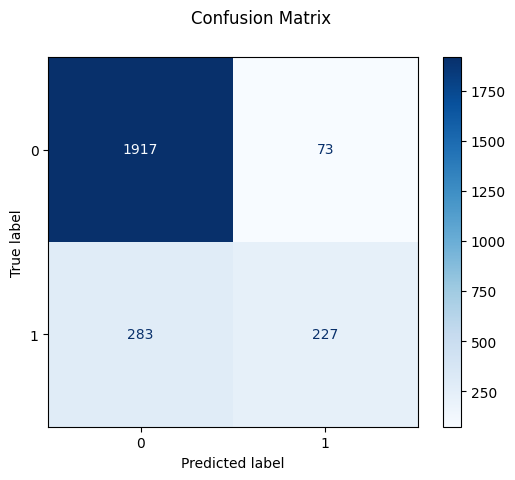

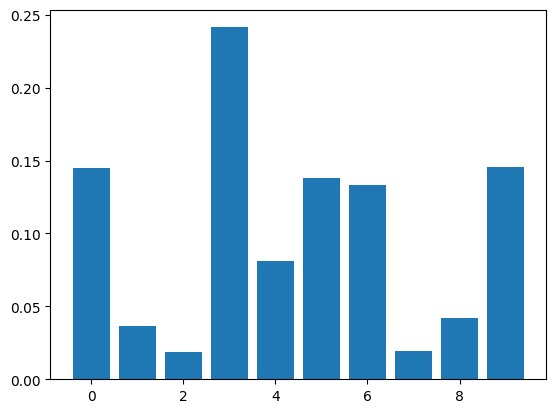

In [92]:
#Muestra reporte de clasificación
y_predict = Model_MRF.predict(X_validation_MRL)
print(classification_report(Y_validation_MRL, y_predict, labels=[0,1]))
#Matriz de Confusión
categorias = ["0","1"]
fig=ConfusionMatrixDisplay.from_estimator(Model_MRF, X_validation_MRL, Y_validation_MRL,display_labels=categorias, cmap="Blues")  
fig.figure_.suptitle("Confusion Matrix")
plt.show()
#Grafica la importancia de las características
importance=Model_MRF.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [93]:
#Regresión Logistica - José Lara
#Copiar el DataFrame original para evitar problemas de referencia
df_rl = df.copy()
df_rl.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [94]:
# Aplicar Label Encoding a las variables categóricas
df_rl_encoded = df_rl.copy()
label_encoder = LabelEncoder()
df_rl_encoded['Geography'] = label_encoder.fit_transform(df_rl['Geography'])
df_rl_encoded['Gender'] = label_encoder.fit_transform(df_rl['Gender'])
df_rl_encoded.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [95]:
# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = np.array(df_rl_encoded.drop(['Exited'], axis='columns'))
y = np.array(df_rl_encoded['Exited'])
X.shape

(10000, 10)

In [96]:
# dividir el conjunto de datos en test y train a un 80% y 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [97]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
# Entrenamiento del Modelo
rl_model = linear_model.LogisticRegression(C=1, penalty='l1', solver='liblinear') # Ya optimizado por hiperparámetros
rl_model.fit(X_train,Y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [99]:
# Obtener el accuracy del modelo
y_pred = rl_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy del modelo de Regresión Logística: ", accuracy)

Accuracy del modelo de Regresión Logística:  0.8105


                precision    recall  f1-score   support

No Abandonaron       0.83      0.97      0.89      1613
   Abandonaron       0.53      0.16      0.25       387

      accuracy                           0.81      2000
     macro avg       0.68      0.56      0.57      2000
  weighted avg       0.77      0.81      0.77      2000



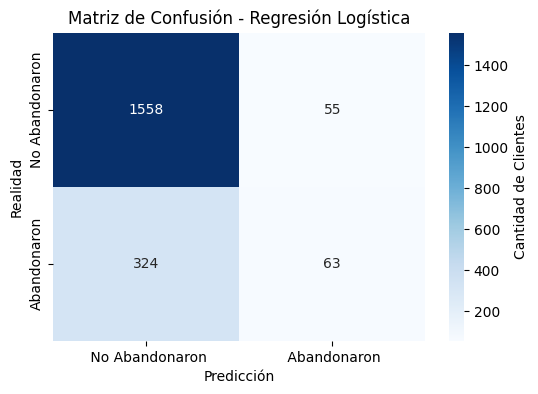

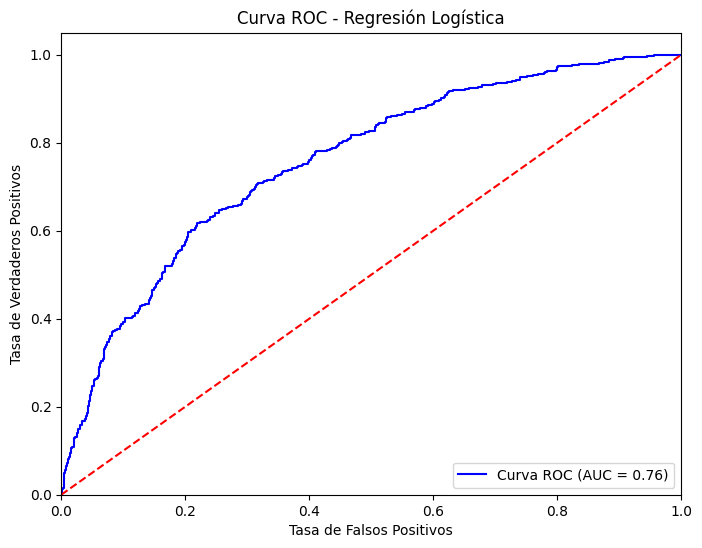

In [100]:
# Reporte de clasificación
# Generar el reporte de clasificación
report = classification_report(Y_test, y_pred, target_names=["No Abandonaron", "Abandonaron"])
print(report)
# Crear la matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)
# Convertir la matriz de confusión en un DataFrame para facilitar la visualización
conf_matrix_df = pd.DataFrame(conf_matrix, index=["No Abandonaron", "Abandonaron"], columns=[" No Abandonaron", " Abandonaron"])
# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar=True, 
            cbar_kws={'label': 'Cantidad de Clientes'})  

plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()
#Curva ROC y AUC
# Calcular las probabilidades de predicción
y_pred_proba = rl_model.predict_proba(X_test)[:, 1]
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
# Calcular el AUC
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()


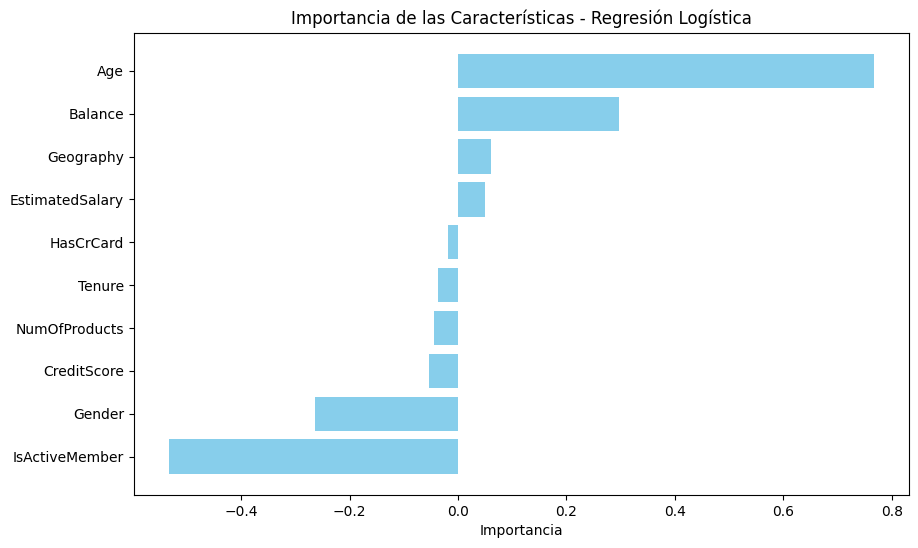

In [101]:
#feature importances regresión logistica
importance = rl_model.coef_[0]
# Crear un DataFrame para las características y sus importancias
feature_importance_df = pd.DataFrame({'Feature': df_rl_encoded.columns[:-1], 'Importance': importance})
# Ordenar por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características - Regresión Logística')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la característica más importante en la parte superior
plt.show()


In [102]:
#Decisión Tree - Gabriela
df_dt = df_encode.copy()

In [103]:
X = df_dt.drop(columns=['Exited'])  
y = df_dt['Exited']  

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [105]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [106]:
print("Precisión:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No Abandonaron", "Abandonaron"]))

Precisión: 0.782
                precision    recall  f1-score   support

No Abandonaron       0.88      0.85      0.86      1607
   Abandonaron       0.45      0.52      0.49       393

      accuracy                           0.78      2000
     macro avg       0.67      0.68      0.67      2000
  weighted avg       0.80      0.78      0.79      2000



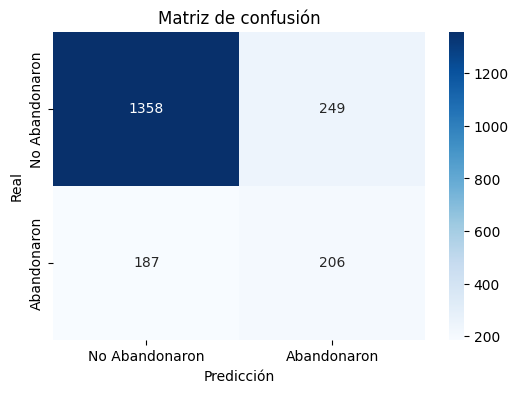

In [107]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Abandonaron', 'Abandonaron'], yticklabels=['No Abandonaron', 'Abandonaron'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

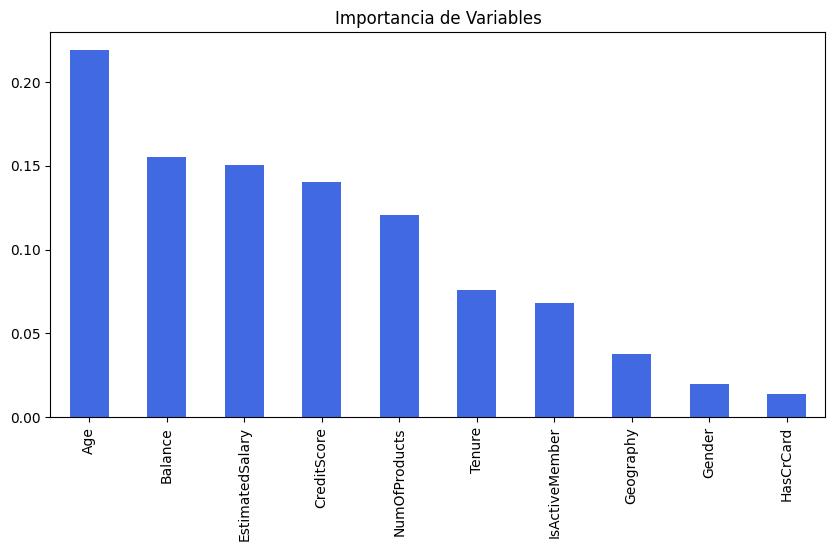

In [108]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
feature_importances.plot(kind='bar', color='royalblue')
plt.title('Importancia de Variables')
plt.show()

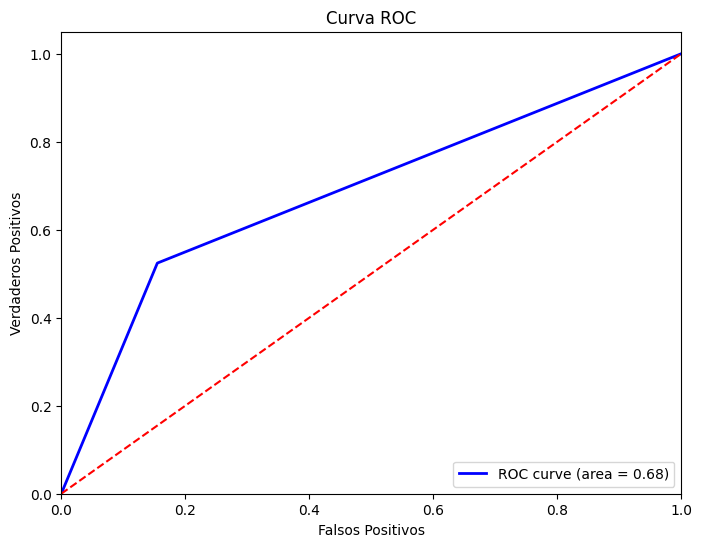

In [109]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [110]:
#Light GBM -Justin
# Separar features (X) y target (y)
X = df_encode.drop(columns=["Exited"])
y = df_encode["Exited"]


In [111]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
precisions = []
recalls = []
gini_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    gini = 2 * roc_auc_score(y_test, y_proba) - 1

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    gini_scores.append(gini)
    #print(f"Fold {fold} - F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Gini: {gini:.4f}")
print("\nPromedios:")
print(f"F1 promedio: {np.mean(f1_scores):.4f}")
print(f"Precision promedio: {np.mean(precisions):.4f}")
print(f"Recall promedio: {np.mean(recalls):.4f}")
print(f"Gini promedio: {np.mean(gini_scores):.4f}")

[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790
[LightGBM] [Info] Start training from score -1.363790
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] [binary:

[LightGBM] [Info] Number of positive: 2037, number of negative: 7963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203700 -> initscore=-1.363328
[LightGBM] [Info] Start training from score -1.363328


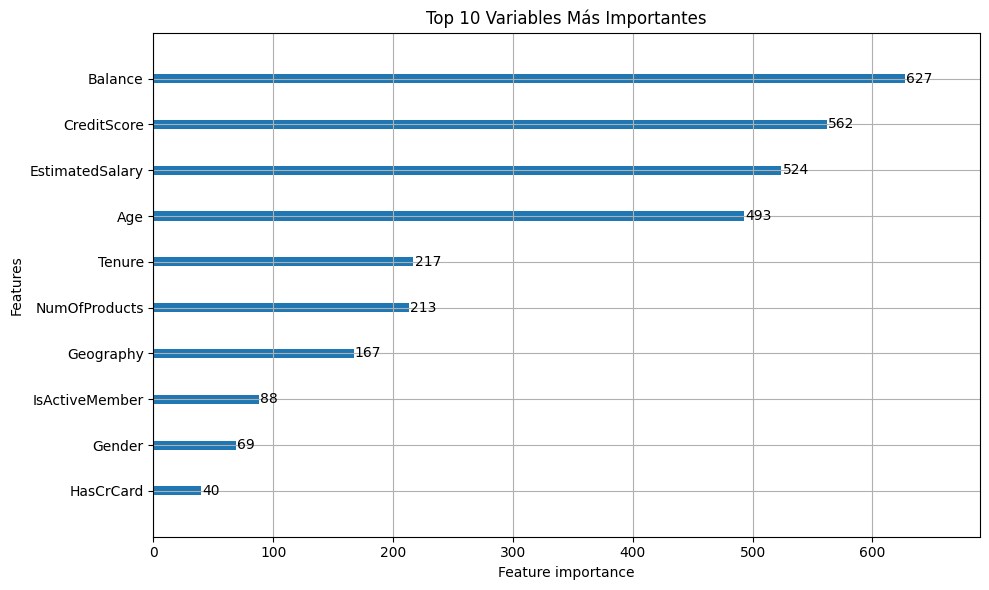

In [112]:
final_model = lgb.LGBMClassifier(random_state=42)
final_model.fit(X, y)
lgb.plot_importance(final_model, 
                    max_num_features=10,     
                    importance_type='split',  
                    figsize=(10, 6))
plt.title("Top 10 Variables Más Importantes")
plt.tight_layout()
plt.show()

In [113]:
#KNN- José V
df_knn = df
X = df_knn.drop('Exited', axis=1)
y = df_knn['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
# Definir columnas categóricas y numéricas
cat_features = ['Geography', 'Gender']
num_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 
    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
    'EstimatedSalary'
]

# Preprocesador: One-Hot Encoding para categóricas y escalado para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)
pipeline = imbpipeline([('preprocessor', preprocessor),
                       ('model', KNeighborsClassifier())])


In [114]:
# Definir la grilla de hiperparámetros
param_grid = {
    'model__n_neighbors': list(range(3, 20, 2)),  # Valores de k
    'model__weights': ['uniform', 'distance'],     # Ponderación por distancia
    'model__metric': ['euclidean', 'manhattan']   # Métricas de distancia
    
}

# Búsqueda con validación cruzada (5 folds)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',  # Métrica para evaluar: ROC-AUC
    verbose=1,
    n_jobs=-1
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Geography',
                                                                          'Gender']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary'])])),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__metric': ['euclidean', 'manhattan'],
                         'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'model__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

Mejores hiperparámetros: {'model__metric': 'euclidean', 'model__n_neighbors': 19, 'model__weights': 'distance'}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1593
           1       0.81      0.31      0.45       407

    accuracy                           0.84      2000
   macro avg       0.83      0.65      0.68      2000
weighted avg       0.84      0.84      0.82      2000


ROC-AUC: 0.8322529000495101
Opitmo F1: 0.60
Threshold optimo:0.3126836096222917


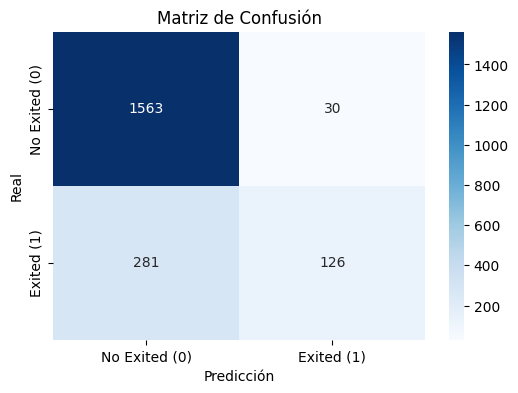

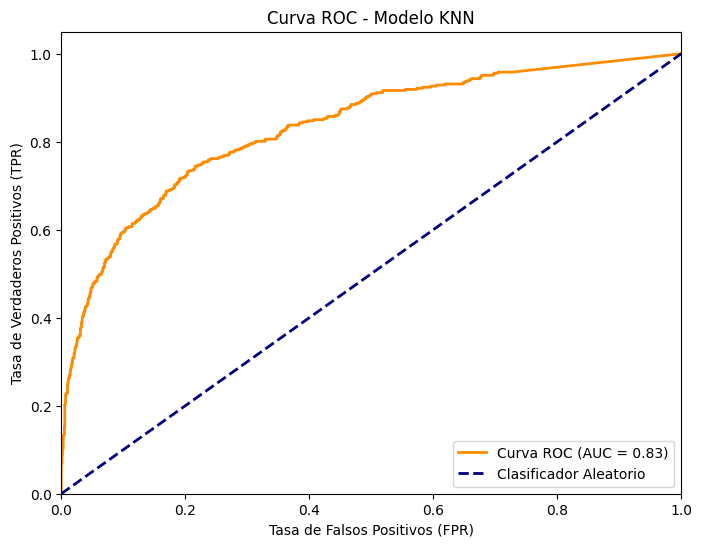

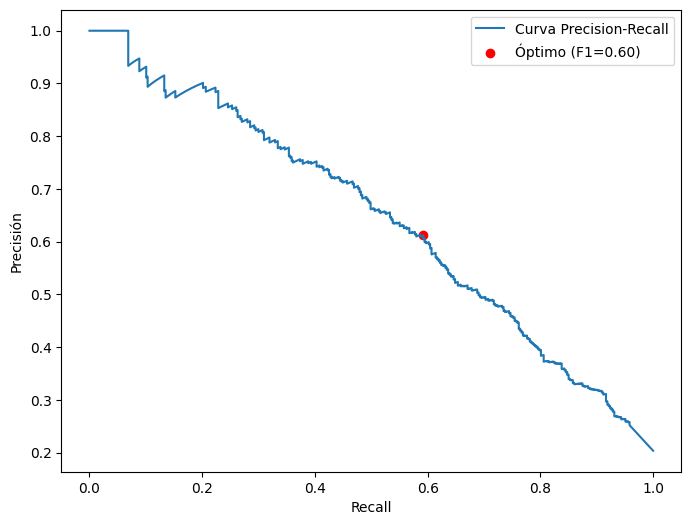

In [115]:
print("Mejores hiperparámetros:", grid_search.best_params_)

# Predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilidades para ROC-AUC

# Reporte de clasificación y métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba))
# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)
# Encontrar el threshold que maximiza F1-Score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f'Opitmo F1: {f1_scores[optimal_idx]:.2f}')
print(f'Threshold optimo:{optimal_threshold}')

# Crear gráfico matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Exited (0)', 'Exited (1)'], 
            yticklabels=['No Exited (0)', 'Exited (1)'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Crear gráfico curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo KNN')
plt.legend(loc='lower right')
plt.show()

#Grafico optimal f1
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Curva Precision-Recall')
plt.scatter(recall[optimal_idx], precision[optimal_idx], c='red', 
            label=f'Óptimo (F1={f1_scores[optimal_idx]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend()
plt.show()

## 6. Evaluación del Modelo
- Métricas de evaluación.
- Interpretación de resultados.
- Ajustes necesarios.

In [116]:
# Evaluación del modelo


## 7. Visualización de Resultados
- Crear visualizaciones relevantes.
- Mostrar resultados clave.

In [117]:
# Visualizaciones finales


## 8. Conclusiones y Recomendaciones
- Conclusiones generales basadas en el análisis.
- Recomendaciones prácticas para el negocio.

## 9. Documentación Técnica
- Explicación de cómo ejecutar el proyecto paso a paso.
- Herramientas utilizadas con breve descripción y enlaces.
- Repositorio con código/documentación si aplica.

## 10. Recursos Adicionales
- Enlaces útiles.
- Lecturas recomendadas.
- Otros materiales de apoyo.